# **Maestría en Inteligencia Artificial Aplicada**

## Curso: **Análisis de grandes volúmenes de datos**

### Tecnológico de Monterrey

### Dr. Nestor Velasco Bermeo

## Avance de proyecto 4: Sistema de Recomendación

### **Sistema de recomendacion de prendas basado en SVD**

#### **Nombres y matrículas de los integrantes del equipo:**

* Salvador Martínez Morales - A01273366
* Jhamyr Arnulfo Alcalde Oballe - A01795401
* Sebastian Toro Salgado – A01793644


In [55]:
# librerías

import numpy as np
import pandas as pd
import gdown
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [23]:
'''
    Cargamos nuestro data set con los rankins
    
    Como podemos ver contiene las columnas: 
        fit: fit feedback
        user_id: a unique id for the customer
        bust: bust measurement of customer
        item_id: unique product id
        weight: weight of the product
        rating: dating of the product 0-10
        rented for: reason of rent
        review_text: customer comments
        body type: clothe body type
        review_summary: short customer comments
        category: the category of the product
        height: height of the customer
        size: the standardized size of the product
        age: customer age
        review_date: date of review
'''

df = pd.read_json('renttherunway_final_data.json', lines=True)
df.head(5)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158648 entries, 0 to 158647
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fit             158648 non-null  object 
 1   user_id         158648 non-null  int64  
 2   bust size       143493 non-null  object 
 3   item_id         158648 non-null  int64  
 4   weight          133945 non-null  object 
 5   rating          158582 non-null  float64
 6   rented for      158639 non-null  object 
 7   review_text     158648 non-null  object 
 8   body type       146658 non-null  object 
 9   review_summary  158648 non-null  object 
 10  category        158648 non-null  object 
 11  height          158090 non-null  object 
 12  size            158648 non-null  int64  
 13  age             157861 non-null  float64
 14  review_date     158648 non-null  object 
dtypes: float64(2), int64(3), object(10)
memory usage: 18.2+ MB


In [25]:
# Contar valores nulos por columna
null_counts = df.isnull().sum()

# Mostrar el resultado
print(null_counts)

fit                   0
user_id               0
bust size         15155
item_id               0
weight            24703
rating               66
rented for            9
review_text           0
body type         11990
review_summary        0
category              0
height              558
size                  0
age                 787
review_date           0
dtype: int64


In [28]:
'''
    Extraemos las columnas 'user_id' 'item_id' 'rating' que serán utilizadas para nuestro análisis
'''
columnas = ['user_id','item_id','rating'] 
my_dt = df[columnas]

my_dt.head(5)

,user_id,item_id,rating
0,420272,2260466,10.0
1,273551,153475,10.0
2,360448,1063761,10.0
3,909926,126335,8.0
4,151944,616682,10.0


In [29]:
'''
    Una vez que tenemos el data set unificado, podemos calcular el promedio de calificaciones por cada prenda
'''

my_dt.groupby('item_id')['rating'].mean().head()

item_id
123373    8.793651
123793    9.554277
124204    9.306061
124553    8.591687
125424    8.949602
Name: rating, dtype: float64

In [30]:
'''
    El ordenamiento anterior tiene un problema, en caso de que una prenda solo se haya calificado una sola vez con calificación de 10
    aparecerá en los primeros lugares, sin embargo, eso no significa que sea del agrado para la mayoría de usuarios
    por lo que, haremos un conteo de los ranking por prenda
'''

my_dt.groupby('item_id')['rating'].count().sort_values(ascending=False).head()

item_id
126335    1801
174086    1428
123793    1391
132738    1289
145906    1250
Name: rating, dtype: int64

In [31]:
my_dt["item_id"].nunique()

5773

Para contrarestar el afecto anteriormente descrito, se generará un nuevo data set agregando las columnas rating y numero de ratings (calificaciones)

In [32]:
ratings_mean_count = pd.DataFrame(my_dt.groupby('item_id')['rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(my_dt.groupby('item_id')['rating'].count())
ratings_mean_count.head()

,rating,rating_counts
item_id,,
123373,8.793651,567
123793,9.554277,1391
124204,9.306061,660
124553,8.591687,409
125424,8.949602,377


<Axes: >

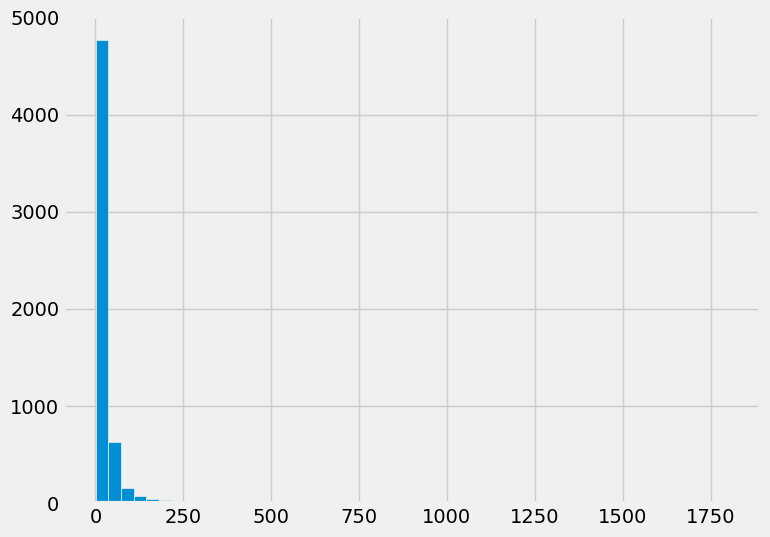

In [33]:
'''
    Ahora graficaremos el numero de calificaciones representada por la columna rating_counts de nuestro data set.
    De los resultados podemos observar que tenemos que la mayoría de prendas han recibido menos de 100 calificaciones
    Hay prendas que no tienen más de 100 recomendaciones
'''

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Axes: >

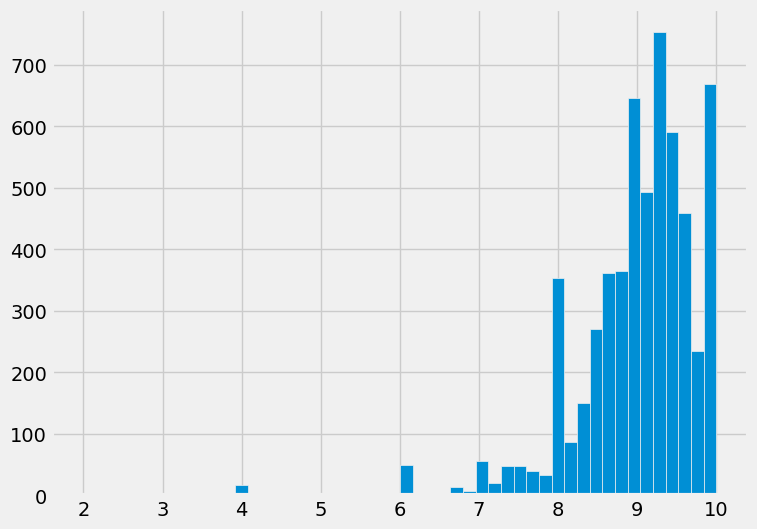

In [34]:
'''
    Como podemos observar en el siguietne histograma, la mayoría de calificaciones se concentran entre 8 y 10
'''

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50)

# Similutudes entre prendas

In [41]:
ratings_mean_count.groupby('item_id')['rating_counts'].mean()

item_id
123373      567.0
123793     1391.0
124204      660.0
124553      409.0
125424      377.0
            ...  
2963850      11.0
2964470       2.0
2965009       3.0
2965924       3.0
2966087       6.0
Name: rating_counts, Length: 5773, dtype: float64

In [42]:
ratings_mean_count.shape

(5773, 2)

In [43]:
'''
   Extraemos las prendas con menos de 10 comentarios
'''
rare_clothes = ratings_mean_count[ratings_mean_count.groupby('item_id')['rating_counts'].mean() <= 10].index
rare_clothes.shape

(2684,)

In [44]:
'''
    De nuestro data set original se eliminan aquellas prendas con pocos comentarios
'''
common_clothes = my_dt[~my_dt["item_id"].isin(rare_clothes)]
common_clothes.shape

(146175, 3)

In [45]:
'''
    Se genera una matriz con los titulos y sus correspondientes ratings
'''
user_clothe_rating = common_clothes.pivot_table(index='user_id', columns='item_id', values='rating')
user_clothe_rating.head()

item_id,123373,123793,124204,124553,125424,125465,125564,126335,127081,127495,...,2945782,2948324,2952142,2954118,2955585,2955734,2958376,2960969,2962646,2963850
user_id,,,,,,,,,,,,,,,,,,,,,
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Función para recomendaciones 

In [46]:
def clothes_recommend(clothe, head):
    
    if clothe in user_clothe_rating.columns:
        clothes_rating = user_clothe_rating[clothe] # Prenda base para correlación
        corr_clothes = user_clothe_rating.corrwith(clothes_rating) # Función de correlación
        result_df = pd.DataFrame(corr_clothes, columns=['Correlation'])
        result_df.dropna(inplace=True)
        result_df = result_df.join(ratings_mean_count['rating_counts'])
        result_df = result_df.sort_values('Correlation', ascending=False).head(head)
        print('Si rentaste la prenda {}, te pueden interesar las siguientes prendas:'.format(clothe))
        print(result_df[1:10])
    else:
        print(f"La columna '{clothe}' no existe en el DataFrame.")

In [57]:
clothes_recommend(127495,11)

Si rentaste la prenda 127495, te pueden interesar las siguientes prendas:
         Correlation  rating_counts
item_id                            
153475           1.0            444
1447941          1.0             65
293358           1.0             30
2863546          1.0             24
532135           1.0            231
1598962          1.0             54
1050242          1.0             82
127495           1.0            381
833599           1.0             47


## Análisis de desempeño

### Medición del Tiempo de Ejecución

In [58]:
import timeit

def measure_time():
    setup_code = '''
import numpy as np
import pandas as pd

# Carga DF
df = pd.read_json('renttherunway_final_data.json', lines=True)
columnas = ['user_id','item_id','rating'] 
my_dt = df[columnas]

ratings_mean_count = pd.DataFrame(my_dt.groupby('item_id')['rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(my_dt.groupby('item_id')['rating'].count())

rare_clothes = ratings_mean_count[ratings_mean_count.groupby('item_id')['rating_counts'].mean() <= 10].index

common_clothes = my_dt[~my_dt["item_id"].isin(rare_clothes)]

user_clothe_rating = common_clothes.pivot_table(index='user_id', columns='item_id', values='rating')

def clothes_recommend(clothe, head):

    if clothe in user_clothe_rating.columns:
        clothes_rating = user_clothe_rating[clothe] # Prenda base para correlación
        corr_clothes = user_clothe_rating.corrwith(clothes_rating) # Función de correlación
        result_df = pd.DataFrame(corr_clothes, columns=['Correlation'])
        result_df.dropna(inplace=True)
        result_df = result_df.join(ratings_mean_count['rating_counts'])
        result_df = result_df.sort_values('Correlation', ascending=False).head(head)
        return result_df[1:10]
    else:
        return None
        '''

    test_code = '''
    clothes_recommend(127495,11)
'''

    times = timeit.repeat(setup=setup_code, stmt=test_code, repeat=3, number=5)
    print(f'Tiempo de ejecución: {min(times)} segundos')

measure_time()

Tiempo de ejecución: 2.940967200000159 segundos


### Perfilado del Código con cProfile

In [59]:
import cProfile

def clothes_recommend(clothe, head):

    if clothe in user_clothe_rating.columns:
        clothes_rating = user_clothe_rating[clothe] # Prenda base para correlación
        corr_clothes = user_clothe_rating.corrwith(clothes_rating) # Función de correlación
        result_df = pd.DataFrame(corr_clothes, columns=['Correlation'])
        result_df.dropna(inplace=True)
        result_df = result_df.join(ratings_mean_count['rating_counts'])
        result_df = result_df.sort_values('Correlation', ascending=False).head(head)
        return result_df[1:10]
    else:
        return None
    
cProfile.run('clothes_recommend(127495,11)')

         581197 function calls (565643 primitive calls) in 2.760 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    2.760    2.760 3761528363.py:3(clothes_recommend)
        2    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1033(_handle_fromlist)
        1    0.000    0.000    2.760    2.760 <string>:1(<module>)
    15464    0.006    0.000    0.006    0.000 __init__.py:34(using_copy_on_write)
        4    0.000    0.000    0.000    0.000 __init__.py:42(warn_copy_on_write)
        3    0.000    0.000    0.000    0.000 __init__.py:55(using_pyarrow_string_dtype)
        1    0.000    0.000    0.000    0.000 _asarray.py:108(<setcomp>)
        1    0.000    0.000    0.000    0.000 _asarray.py:27(require)
        2    0.000    0.000    0.000    0.000 _dtype.py:24(_kind_name)
        2    0.000    0.000    0.000    0.000 _dtype.py:330(_name_includes_bit_suffix)
        2    0.000    0.

### Precision y Recall

Estas métricas se utilizan para evaluar la calidad de las recomendaciones en términos de cuántas de las recomendaciones son relevantes y cuántos de los elementos relevantes han sido recomendados.

In [72]:
mean_ratings = common_clothes.groupby('item_id')['rating'].mean()
mean_ratings_sorted = mean_ratings.sort_values(ascending=False)
print(mean_ratings_sorted)

item_id
1384226    10.000000
1451390    10.000000
1011971    10.000000
1817701    10.000000
1888892    10.000000
             ...    
2186524     6.941176
753871      6.923077
679340      6.750000
796216      6.727273
2626811     6.666667
Name: rating, Length: 3089, dtype: float64


In [79]:
# Filtrar por valor igual a 10
mean_ratings_equal_to_10 = mean_ratings[mean_ratings >= 9]
# Contar los elementos
relevant_items = mean_ratings_equal_to_10.count()
print("Número de elementos con promedio de calificación igual a 9:", relevant_items)

Número de elementos con promedio de calificación igual a 9: 1933


In [127]:
def clothes_recommend(clothe, head):
    
    if clothe in user_clothe_rating.columns:
        clothes_rating = user_clothe_rating[clothe] # Prenda base para correlación
        corr_clothes = user_clothe_rating.corrwith(clothes_rating) # Función de correlación
        result_df = pd.DataFrame(corr_clothes, columns=['Correlation'])
        result_df.dropna(inplace=True)
        result_df = result_df.join(ratings_mean_count['rating_counts'])
        result_df = result_df.sort_values('Correlation', ascending=False)
        mean_ratings_equal_to_10 = result_df[result_df['Correlation'] >= 0.8]
        return(mean_ratings_equal_to_10)
    else:
        return None

In [115]:
recommended_items = clothes_recommend(127495,11)
recommended_items.reset_index(inplace=True)
recommended_items.rename(columns={'index': 'item_id'}, inplace=True)

In [132]:
def precision_at_k(recommended_items, relevant_items, k):
    recommended_k = recommended_items[:k]
    relevant_set = set(relevant_items)
    recommended_set = set(recommended_k)
    return len(recommended_set & relevant_set) / len(recommended_set)

def recall_at_k(recommended_items, relevant_items, k):
    recommended_k = recommended_items[:k]
    relevant_set = set(relevant_items)
    recommended_set = set(recommended_k)
    return len(recommended_set & relevant_set) / len(relevant_set)

In [134]:
precision = precision_at_k(recommended_items['item_id'], mean_ratings_equal_to_10.index, k=2)
recall = recall_at_k(recommended_items['item_id'], mean_ratings_equal_to_10.index, k=2)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Precision: 1.0
Recall: 0.0010346611484738748


### Coverage

Esta métrica mide la proporción de elementos que el sistema de recomendación puede recomendar. Es una métrica útil para evaluar la diversidad del sistema.

In [138]:
def coverage(recommended_items, all_items):
    recommended_set = set(recommended_items)
    all_items_set = set(all_items)
    return len(recommended_set & all_items_set) / len(all_items_set)

In [139]:
coverage = coverage(recommended_items['item_id'], common_clothes['item_id'])
print(f'coverage: {coverage}')

coverage: 0.00712204596956944


### Mean Average Precision (MAP)

Esta métrica evalúa la precisión promedio para las listas de recomendaciones, ponderada por la posición de los elementos relevantes en la lista.

In [152]:
def average_precision(recommended_items, relevant_items):
    relevant_set = set(relevant_items)
    if not relevant_set:
        return 0.0
    score = 0.0
    num_hits = 0.0
    for i, item in enumerate(recommended_items):
        if item in relevant_set:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(relevant_set), len(recommended_items))

In [153]:
average_precision = average_precision(recommended_items['item_id'], common_clothes['item_id'])

print(f'average_precision: {average_precision}')

average_precision: 1.0
